# Introduction

This notebook compares different trace synthesis.

In [1]:
import collections
from collections import defaultdict
import itertools
import pandas as pd
import numpy as np
import datetime
import pulp
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline
from IPython.display import display, HTML
import datetime
import seaborn as sns

import malloovia

from malloovia_syntraces import Period

BASE_DIR = '/tmp'
TRACE_DIR = F'{BASE_DIR}/spects'

frac_gap_phase1 = 0.002

def get_infrastructure(base_perf_hour, max_vms):
    '''Returns the workloads, instances and performances.
    
    Args:
    - base_perf_hour: performance in requests per hour of the base VM   
    - max_vms: maximum number of VMs in limiting sets
    '''
    region = malloovia.LimitingSet("r1", name="us.west", max_vms=max_vms)

    az_count = 3 # az = availability zone
    azs = [malloovia.LimitingSet('AZ' + str(i), name='AZ' + str(i), max_vms=max_vms)
          for i in range(1, az_count+1)]

    instances = [
        malloovia.InstanceClass(
            id='c4.large', name='c4.large',
            limiting_sets=(region,), is_reserved=False,
            price=0.124, time_unit='h', max_vms=max_vms),
        malloovia.InstanceClass(
            id='c4.xlarge', name='c4.xlarge',
            limiting_sets=(region,), is_reserved=False,
            price=0.249, time_unit='h', max_vms=max_vms),
        malloovia.InstanceClass(
            id='m4.large', name='m4.large',
            limiting_sets=(region,), is_reserved=False,
            price=0.117, time_unit='h', max_vms=max_vms),
        malloovia.InstanceClass(
            id='m4.xlarge', name='m4.xlarge',
            limiting_sets=(region,), is_reserved=False,
            price=0.234, time_unit='h', max_vms=max_vms),
        ]

    reserved_prices = {
        'c4.large': 0.0793379,
        'c4.xlarge': 0.159703196,
        'm4.large': 0.0793379,
        'm4.xlarge': 0.158789954}

    for name, price in reserved_prices.items():
        for zone in azs:
            instances.append(malloovia.InstanceClass(
                    id=name+zone.name, name=name,
                    limiting_sets=(zone,), is_reserved=True,
                    price=price, time_unit='h', max_vms=0))

    # Performances
    app0 = malloovia.App("a0", "Web server")

    base_perf = base_perf_hour # It was 12300 for m3.medium, with ECU=3
    perfs = {
        'c4.large': (base_perf*8/3), # ECU = 8
        'c4.xlarge': (base_perf*16/3), # ECU = 16
        'm4.large': (base_perf*6.5/3), # ECU = 6.5
        'm4.xlarge': (base_perf*13/3)} # ECU = 13

    print('Max perf (req/mins):', perfs['m4.xlarge']*max_vms*2/60)

    perf_values = {}
    for i in instances:
        perf_values[i] = {app0: perfs[i.name]}

    performances = malloovia.PerformanceSet(
        id="perfs",
        values=malloovia.PerformanceValues(perf_values),
        time_unit='h'
    )

    return tuple(instances), performances, app0

def get_workloads(workload_list, app, units):
    '''Receives a workload list, an app, and a divisor for prices and
    performances and returns the workloads.

    Args:
    - workload_list: a list of integers which is the values for the Workload
      object
    - app: Application object for the workload
    - units: a string indicating if the trace is in seconds ('s'),
      minutes ('m') or hours ('h').
    '''
    # Long term workload prediction of each app, for Phase I
    ltwp_app0 = malloovia.Workload(
        "ltwp0", description="requests per time unit",
        app=app,
        values=tuple(workload_list),
        time_unit=units
    )

    return (ltwp_app0,)

def solve_p1(workload_list_p1, units_p1, base_perf_hour, max_vms, frac_gap_phase1, threads, max_seconds):
    '''Creates an allocation problem with the workload in some units and
    solves phase I.

    Args:
    - workload_list_p1: list of integers with the workload for phase I
    - units_p1: time units used in the workload for phase I (valid values:
      's', 'm', 'h')
    - base_perf_hour: performance in requests per hour of the base VM   
    - max_vms: maximum number of VMs in limiting sets
    - frac_gap_phase1: frac_gap to use with the CBC solver
    - threads: number of threads to use in PULP
    - max_seconds: number of seconds to use in PULP
    

    Returns:
    The solution for phase I.
    '''
    instances_p1, performances_p1, app = get_infrastructure(base_perf_hour, max_vms)

    workloads_p1 = get_workloads(workload_list_p1, app, units_p1)
    problem_p1 = malloovia.Problem(
        id="p_p1_{}".format(units_p1),
        name="Example problem",
        workloads=workloads_p1,
        instance_classes=instances_p1,
        performances=performances_p1
    )

    solver = pulp.COIN(maxSeconds=max_seconds, threads=threads, msg=1,
                       fracGap=frac_gap_phase1)
    return malloovia.PhaseI(problem_p1).solve(solver=solver)

def solve_p1_from_csv_file(filename, nsecs, base_perf_hour, max_vms, threads, max_seconds,
                           scaling_factor=None):
    '''From the filename of a csv file containing dates and workloads in minutes,
    compute the solution of phase 1.
    
    Args:
    - filename: string with the name of a csv file containing dates and
      workloads in minutes
    - nsecs: number of seconds of the trace to use. By default
    - base_perf_hour: performance in requests per hour of the base VM
    - max_vms: maximum number of VMs in limiting sets
    - threads: number of threads to use in PULP
    - max_seconds: number of seconds to use in PULP
    - scaling_factor: factor to multiply each element in the workload
        
    Returns:
    The solution for phase I.
    '''
    df_secs = pd.read_csv(filename, index_col=0, parse_dates=True, nrows=nsecs)
    df_mins = df_secs.resample('T', label='right').max()*Period.minute.in_seconds()

    if scaling_factor != None:
        df_mins.iloc[:,0] = np.ceil(df_mins.iloc[:,0] * scaling_factor).astype('int')
    
    workload_mins_as_list = df_mins.squeeze().tolist()
    
    print('Max in trace:', max(workload_mins_as_list))
    return solve_p1(workload_mins_as_list, units_p1='m', base_perf_hour=base_perf_hour,
                    max_vms=max_vms, frac_gap_phase1=frac_gap_phase1, threads=threads,
                    max_seconds=max_seconds)

def run_exp(name, exp_dict, traces, nsecs, base_perf_hour, max_vms, threads, max_seconds, scaling_factor):
    '''Run an experiment with the same parameters for several traces.
    
    Args:
    - name: string with the name of the experiment
    - exp_dict: dictionary where the experiment will be added
    - traces: list of strings with the name of a csv file containing dates and
      workloads in seconds. They have to be in /tmp
    - nsecs: number of seconds of the trace to use. By default, use all
    - base_perf_hour: performance in requests per hour of the base VM
    - max_vms: maximum number of VMs in limiting sets
    - threads: number of threads to use in PULP
    - max_seconds: number of seconds to use in PULP
    - scaling_factor: factor to multiply each element in the workload
        
    Modifies:
    exp_dict, adding the results for the experiment
    '''
    exp_dict[name] = {}
    exp_dict[name]['base_perf_hour'] = base_perf_hour
    exp_dict[name]['max_vms'] = max_vms
    exp_dict[name]['scaling_factor'] = scaling_factor
    
    sols = {}
    for trace in traces:
        print(f'Solving {trace}')
        sols[trace] = solve_p1_from_csv_file(
            f'{TRACE_DIR}/{trace}.csv.gz',
            nsecs=nsecs,
            base_perf_hour=base_perf_hour,
            max_vms=max_vms,
            threads=threads,
            max_seconds=max_seconds,
            scaling_factor=scaling_factor)
        
        status = sols[trace].solving_stats.algorithm.status
        print(f'status: {status}')
        
        time = sols[trace].solving_stats.solving_time
        print(f'Time to solve: {time:.2f} secs ({time/60:.2f} mins)')

        if status != 1:
            print('Experiment aborted\n')
            break

        print()

        
    exp_dict[name]['sols'] = sols
    
    return

traces_wc98 = [
    # real trace
    'wc98_real', 
       
    # Synthetic traces
    'wc98_smooth',
    'wc98_uniform',
    'wc98_constant',
    'wc98_white',
    'wc98_pink',    
    'wc98_brown',
]

traces_wiki = [
    'wiki_smooth',
    'wiki_uniform',
    'wiki_constant',
    'wiki_white',
    'wiki_pink',    
    'wiki_brown',
]

COLOR_REAL = 'green'
COLOR_SMOOTH = '#348ABD'
COLOR_UNIFORM = 'orange'
COLOR_BROWN = '#7A3907'
COLOR_CONSTANT = 'black'
COLOR_WHITE = 'grey'
COLOR_PINK = 'pink'

COLORS_DICT = {
    'real': COLOR_REAL,
    'smooth': COLOR_SMOOTH,
    'uniform': COLOR_UNIFORM,
    'constant': COLOR_CONSTANT,
    'white': COLOR_WHITE,
    'pink': COLOR_PINK,
    'brown': COLOR_BROWN}
COLORS = [COLOR_REAL, COLOR_SMOOTH, COLOR_UNIFORM, COLOR_CONSTANT, COLOR_WHITE, COLOR_PINK, COLOR_BROWN]

def df_to_color(dataframe):
    return [COLORS_DICT[x] for x in dataframe.columns]

In [2]:
exp_dict = {}

# Experiments

In [3]:
# World cup
run_exp('exp1', exp_dict, traces_wc98,
        base_perf_hour=12300,
        nsecs=84 * Period.day.in_seconds(),
        max_vms=20*100*3,
        max_seconds=8*Period.hour.in_seconds(),
        threads=1,
        scaling_factor=None)

Solving wc98_real
Max in trace: 245340
Max perf (req/mins): 10660000.0
status: 1
Time to solve: 17.48 secs (0.29 mins)

Solving wc98_smooth
Max in trace: 235980
Max perf (req/mins): 10660000.0
status: 1
Time to solve: 18.66 secs (0.31 mins)

Solving wc98_uniform
Max in trace: 197640
Max perf (req/mins): 10660000.0
status: 1
Time to solve: 17.30 secs (0.29 mins)

Solving wc98_constant
Max in trace: 185220
Max perf (req/mins): 10660000.0
status: 1
Time to solve: 1.92 secs (0.03 mins)

Solving wc98_white
Max in trace: 303780
Max perf (req/mins): 10660000.0
status: 1
Time to solve: 28.51 secs (0.48 mins)

Solving wc98_pink
Max in trace: 300120
Max perf (req/mins): 10660000.0
status: 1
Time to solve: 22.03 secs (0.37 mins)

Solving wc98_brown
Max in trace: 291480
Max perf (req/mins): 10660000.0
status: 1
Time to solve: 18.94 secs (0.32 mins)



In [4]:
# Wikipedia, three months
run_exp('exp2', exp_dict, traces_wiki,
        base_perf_hour=12300*10,
        nsecs=3 * Period.month.in_seconds(),
        max_vms=20*100*3,
        max_seconds=8*Period.hour.in_seconds(),
        threads=1,
        scaling_factor=None)

Solving wiki_smooth
Max in trace: 241020
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 6.14 secs (0.10 mins)

Solving wiki_uniform
Max in trace: 237780
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 6.24 secs (0.10 mins)

Solving wiki_constant
Max in trace: 225840
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 4.41 secs (0.07 mins)

Solving wiki_white
Max in trace: 415080
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 30.73 secs (0.51 mins)

Solving wiki_pink
Max in trace: 406380
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 26.35 secs (0.44 mins)

Solving wiki_brown
Max in trace: 400500
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 37.56 secs (0.63 mins)



In [5]:
# Wikipedia, whole year
run_exp('exp3', exp_dict, traces_wiki,
        base_perf_hour=12300*10,
        nsecs=1 * Period.year.in_seconds(),
        max_vms=20*100*3,
        max_seconds=8*Period.hour.in_seconds(),
        threads=1,
        scaling_factor=None)

Solving wiki_smooth
Max in trace: 376620
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 26.93 secs (0.45 mins)

Solving wiki_uniform
Max in trace: 355500
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 24.17 secs (0.40 mins)

Solving wiki_constant
Max in trace: 337800
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 16.04 secs (0.27 mins)

Solving wiki_white
Max in trace: 525780
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 43.28 secs (0.72 mins)

Solving wiki_pink
Max in trace: 595860
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 46.13 secs (0.77 mins)

Solving wiki_brown
Max in trace: 568680
Max perf (req/mins): 106600000.0
status: 1
Time to solve: 55.44 secs (0.92 mins)



# Obtaining information about solutions

In [6]:
def get_df_alloc_p1(alloc):
    return (pd.DataFrame(
                malloovia.allocation_info_as_dicts(
                    alloc = alloc,
                    use_ids=True,
                    include_repeats=True,
                    include_workloads=True,
                    include_timeslot=False))
                .set_index(["repeats", "workload", "app", "instance_class"])
                .unstack()
            )

levels = {}
allocs = {}
summary = {}
all_traces = traces_wc98 + traces_wiki
for exp in exp_dict:
    levels[exp] = {}
    allocs[exp] = {}
    summary[exp] = {}
    print(exp)
    for trace in all_traces:
        print(f'  {trace:<40}', end='')

        if 'sols' not in exp_dict[exp]:
            print('No solutions')
            continue # The experiment didn't finish
            
        if trace not in exp_dict[exp]['sols']:
            print('Not in this experiment')
            continue
            
        try:
            alloc = exp_dict[exp]['sols'][trace].allocation
        except:
            print('Not found')
            continue
            
        summary[exp][trace] = {}
        if alloc != None:
            df_alloc = get_df_alloc_p1(alloc)
            print(f'{len(df_alloc)} workload levels')
            levels[exp][trace] = len(df_alloc)
            summary[exp][trace]['levels'] = len(df_alloc)
            summary[exp][trace]['cost'] = exp_dict[exp]['sols'][trace].solving_stats.optimal_cost
            summary[exp][trace]['solving_time'] = exp_dict[exp]['sols'][trace].solving_stats.solving_time
            summary[exp][trace]['gcd_multiplier'] = exp_dict[exp]['sols'][trace].solving_stats.algorithm.gcd_multiplier
            allocs[exp][trace] = df_alloc
        else:
            print('No alloc')
            levels[exp][trace] = None
            summary[exp][trace]['levels'] = None
            summary[exp][trace]['cost'] = None
            summary[exp][trace]['solving_time'] = None
            summary[exp][trace]['gcd_multiplier'] = exp_dict[exp]['sols'][trace].solving_stats.algorithm.gcd_multiplier

exp1
  wc98_real                               2672 workload levels
  wc98_smooth                             2624 workload levels
  wc98_uniform                            2365 workload levels
  wc98_constant                           682 workload levels
  wc98_white                              3174 workload levels
  wc98_pink                               3093 workload levels
  wc98_brown                              2764 workload levels
  wiki_smooth                             Not in this experiment
  wiki_uniform                            Not in this experiment
  wiki_constant                           Not in this experiment
  wiki_white                              Not in this experiment
  wiki_pink                               Not in this experiment
  wiki_brown                              Not in this experiment
exp2
  wc98_real                               Not in this experiment
  wc98_smooth                             Not in this experiment
  wc98_uniform                

In [7]:
paper_names  = {}
for t in all_traces:
    paper_names[t] = t[5:]

summary_list = []
for e in summary:
    for trace in summary[e]:
        row = {}
        row['name'] = e
        row['trace'] = paper_names[trace]
        row['cost'] = summary[e][trace]['cost']
        row['solving_time'] = summary[e][trace]['solving_time']
        row['levels'] = summary[e][trace]['levels']
        row['gcd_multiplier'] = summary[e][trace]['gcd_multiplier']
        summary_list.append(row)
summary_df = pd.DataFrame(summary_list).set_index(['name', 'trace'])
summary_df

cost  gcd_multiplier  levels  solving_time
name trace                                                       
exp1 real       5806.934768             1.0    2672     17.477268
     smooth     5570.239072             1.0    2624     18.658499
     uniform    5569.144628             1.0    2365     17.303718
     constant   4959.068959             1.0     682      1.923156
     white      6918.419695             1.0    3174     28.509818
     pink       6577.017422             1.0    3093     22.027492
     brown      5509.962599             1.0    2764     18.944591
exp2 smooth     6063.775753             1.0    2159      6.138765
     uniform    6061.722020             1.0    2163      6.240457
     constant   5822.768806             1.0    1583      4.414686
     white      8154.131860             1.0    3602     30.729881
     pink       7805.611685             1.0    4082     26.350830
     brown      6745.127420             1.0    4805     37.558233
exp3 smooth    23258.881445             1.0    3488     26.927571
     uniform   23253.185379             1.0    3399     24.168721
     constant  22285.953871             1.0    2251     16.035048
     white     31216.569881             1.0    4899     43.277155
     pink      30015.321640             1.0    5208     46.126100
     brown     25971.185195             1.0    5678     55.439251

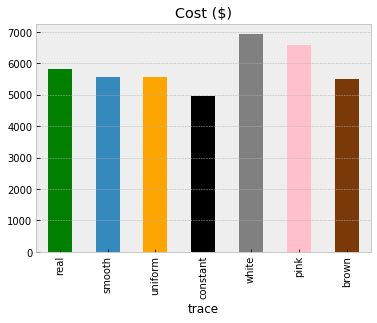

In [8]:
exp_id = 'exp1'

fig, ax = plt.subplots()
summary_df.loc[(exp_id), 'cost'].plot(kind='bar', title='Cost ($)', figsize=(6, 4.2), ax=ax,
                                     color=COLORS)
ax.xaxis.grid(False)
fig.savefig('figs/cost_wc.png', bbox_inches='tight', dpi=300)

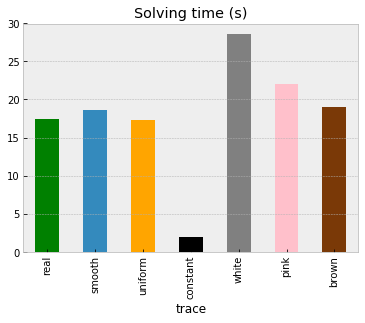

In [9]:
fig, ax = plt.subplots()
summary_df.loc[(exp_id), 'solving_time'].plot(kind='bar', ylim=0, title='Solving time (s)', figsize=(6, 4.2),
                                             color=COLORS)
ax.xaxis.grid(False)
fig.savefig('figs/time_wc.png', bbox_inches='tight', dpi=300)

In [10]:
workloads = {}
for trace in traces_wc98:
    sol = exp_dict[exp_id]['sols'][trace]
    wl = sol.problem.workloads[0].values
    workloads[paper_names[trace]] = wl

df_wls = pd.DataFrame(workloads)
df_wls.head()

,brown,constant,pink,real,smooth,uniform,white
0,780,480,840,1080,840,840,660
1,720,480,780,900,1080,780,660
2,660,480,720,840,780,1140,660
3,600,480,660,1020,840,900,660
4,660,480,720,900,900,840,660


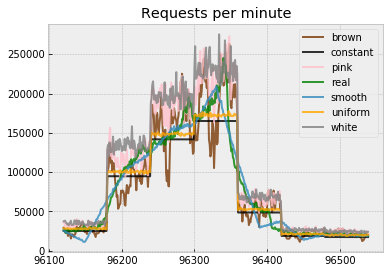

In [11]:
fig, ax = plt.subplots()
start = 66*Period.day.in_minutes()+18*Period.hour.in_minutes()
end = start + 7*Period.hour.in_minutes()
df_wls.iloc[start:end].plot(figsize=(6, 4.2), color=df_to_color(df_wls), alpha=.8, ax=ax,
                           title='Requests per minute')
fig.savefig('figs/trace_minute.png', bbox_inches='tight', dpi=300)

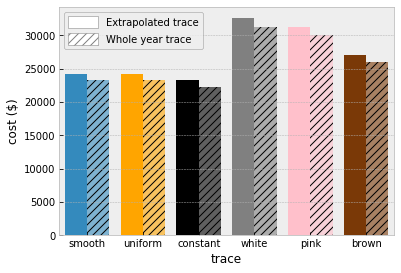

In [12]:
fig, ax = plt.subplots(figsize=(6, 4.2))

cost_df = pd.concat([summary_df.loc['exp2', 'cost']*4, summary_df.loc['exp3', 'cost']], keys=['exp2', 'exp3'])
sns.barplot(data=cost_df.reset_index(), x='trace', y='cost', hue='level_0', ax=ax)
ax.set(ylabel='cost ($)')

# Make legend clearer
leg = ax.axes.get_legend()
extrapolated_patch = matplotlib.patches.Patch(
    facecolor='white', label='Extrapolated trace', edgecolor='grey')
whole_year_patch = matplotlib.patches.Patch(
    facecolor='white', label='Whole year trace', hatch ='///', edgecolor='grey')
plt.legend(
    handles=[extrapolated_patch, whole_year_patch],
    handleheight=1.5, handlelength=3, edgecolor='grey')

num_locations = 6
hatches = itertools.cycle(['', '///'])
colors = itertools.cycle(COLORS[1:]) # Wikipedia doesn't have a real trace
alphas = itertools.cycle([1, 0.6])
for i, bar in enumerate(ax.patches):
    if i % num_locations == 0:
        hatch = next(hatches)
        alpha = next(alphas)
    color = next(colors)
    bar.set_facecolor(color)
    bar.set_alpha(alpha)
    bar.set_hatch(hatch)
    
plt.savefig('figs/cost_wikipedia.png', bbox_inches='tight', dpi=300)

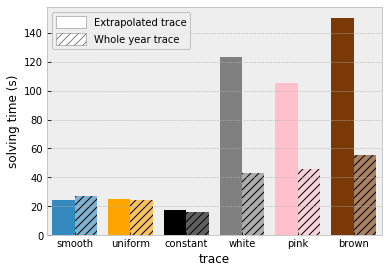

In [13]:
fig, ax = plt.subplots(figsize=(6, 4.2))

time_df = pd.concat([summary_df.loc['exp2', 'solving_time']*4, summary_df.loc['exp3', 'solving_time']],
                    keys=['exp2', 'exp3']).reset_index()
sns.barplot(data=time_df, x='trace', y='solving_time', hue='level_0', ax=ax)
ax.set(ylabel='solving time (s)')

leg = ax.axes.get_legend()
extrapolated_patch = matplotlib.patches.Patch(
    facecolor='white', label='Extrapolated trace', edgecolor='grey')
whole_year_patch = matplotlib.patches.Patch(
    facecolor='white', label='Whole year trace', hatch ='///', edgecolor='grey')
plt.legend(
    handles=[extrapolated_patch, whole_year_patch],
    handleheight=1.5, handlelength=3, edgecolor='grey')

num_locations = 6
hatches = itertools.cycle(['', '///'])
colors = itertools.cycle(COLORS[1:]) # Wikipedia doesn't have a real trace
alphas = itertools.cycle([1, 0.6])
for i, bar in enumerate(ax.patches):
    if i % num_locations == 0:
        hatch = next(hatches)
        alpha = next(alphas)
    color = next(colors)
    bar.set_facecolor(color)
    bar.set_alpha(alpha)
    bar.set_hatch(hatch)
    
plt.savefig('figs/time_wikipedia.png', bbox_inches='tight', dpi=300)